## REFS: https://pdf.sciencedirectassets.com/271454/1-s2.0-S0263224121X00024/1-s2.0-S0263224121000129/main.pdf

In [22]:
import os
import numpy as np
import scipy.io
import pywt

from scipy.signal import hilbert, freqz
from matplotlib import pyplot as plt

from typing import List, Tuple
from kurtogram import fast_kurtogram

# Functions

In [3]:
def Load(file: str) -> Tuple[List]:

    DATA = scipy.io.loadmat(os.path.join('Data', file))
    x = DATA['bearing']['gs'][0][0]
    fs = DATA['bearing']['sr'][0][0][0]
    time = np.transpose(np.arange(0, len(x)) / fs)

    return x, fs, time, DATA


def PSD(f: List, time: List, num: int) -> Tuple[List]:

    dt = abs(time[2] - time[1])
    n = len(time[:num])
    fhat = np.fft.fft(f[:num], n)
    freq = (1/(dt*n))*np.arange(n)
    psd = fhat*np.conj(fhat) / n
    L = np.arange(1, np.floor(n/2), dtype='int')

    return freq, psd, L

def plot_psd(freq, psd, L, title=''):

    plt.figure()
    plt.plot(freq[L], psd[L])
    plt.xlim(freq[L[0]], freq[L[-1]])
    plt.xlabel('Freq [Hz]')
    plt.ylabel('Power Spectral Density')
    plt.title(f'PSD: {title}')




def Spec(f: List, fs: int, title: str=""):

    plt.figure()
    plt.title(title)
    plt.specgram(f, NFFT=1024, Fs=fs, noverlap=120,cmap='jet')
    plt.colorbar()


def wavelet_filter(coefficients, wavelet) -> List:
    
    coeff_arr, coeff_slices = pywt.coeffs_to_array(coefficients)

    Csort = np.sort(np.abs(coeff_arr.reshape(-1)))

    keep = 0.05

    thresh = Csort[int(np.floor((1-keep)*len(Csort)))]
    ind = np.abs(coeff_arr) > thresh
    Cfilt = coeff_arr * ind # Threshold small indices

    coeffs_filt = pywt.array_to_coeffs(Cfilt,coeff_slices,output_format='wavedec')

    # Plot reconstruction
    Arecon = pywt.waverec(coeffs_filt,wavelet=wavelet)

    return Arecon


def env_spectrum(x, fs):

    # analytic_signal = hilbert(x)
    # envelope = np.abs(analytic_signal)

    y_d = np.gradient(np.abs(x))
    analytic_signal = hilbert(y_d)
    envelope = np.abs(analytic_signal)
    
    
    f_env = np.fft.fftfreq(len(envelope), d=1/fs)
    p_env = np.abs(np.fft.rfft(envelope) / len(x))
    
    
    x_env = envelope
    
    return p_env, f_env, x_env, 


def plot_env_spectrum(x_env, x_raw, time):

    plt.figure()
    plt.subplot(2, 1, 1)
    plt.xlim(0.04, 0.06)
    plt.plot(time, x_raw)
    plt.xlabel('Time [s]')
    plt.ylabel('Acceletarion [g]')
    plt.subplot(2, 1, 2)
    plt.plot(time[:len(x_env)], x_env)
    plt.xlim(0.04, 0.06)
    # plt.ylim(0, 1)
    plt.xlabel('Time [s]')
    plt.ylabel('Acceletarion [g]')

def plot_env_spectrum_analysis(f_env, p_env, BP, BPFI=False, BPFO=False, ALL=False):
    
    k = 0
    ncomb = 0
    if ALL: BPFI = BPFO = True

    plt.figure()
    a = next((index for index, value in enumerate(f_env) if value > 1000), -1)
    plt.plot(f_env[3:a], p_env[3:a], label='Envelope Spectrum')
    plt.xlabel("Frequency [Hz]")
    plt.ylabel('Peak Amplitude')
    plt.xlim(0, 1000)
    plt.ylim( 0, 0.5)

    if BPFI:
        values = []
        while k * BP["BPFI"] < 1000: 
            values.append(k * BP["BPFI"])
            k +=1
        harmonics = dict(values=values, name="BPFI")
        plt.vlines(harmonics['values'], 0, 0.5, colors='r', linestyles='--', label=harmonics['name'])
    if BPFO:
        values = []
        while ncomb * BP["BPFO"] < 1000: 
            values.append(ncomb * BP["BPFO"])
            ncomb +=1
        harmonics = dict(values=values, name="BPFO")
        plt.vlines(harmonics['values'], 0, 0.5, colors='#f87915', linestyles='--', label=harmonics['name'])

    plt.legend(framealpha=1)




# Analysis

## Inner Fault 1

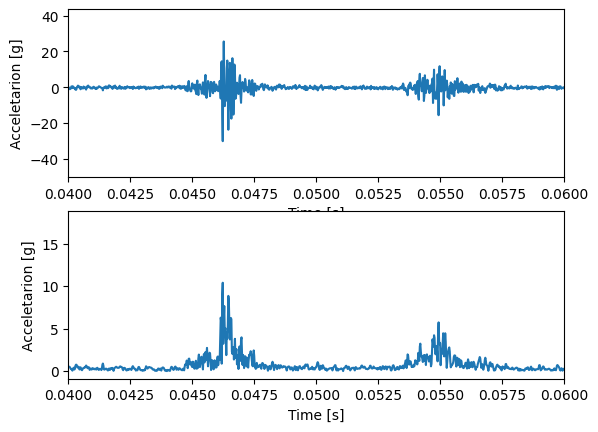

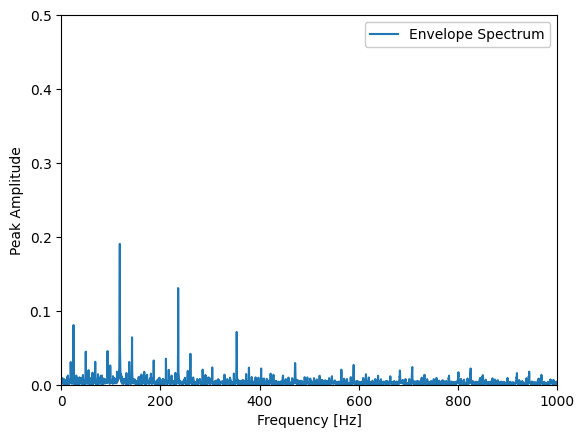

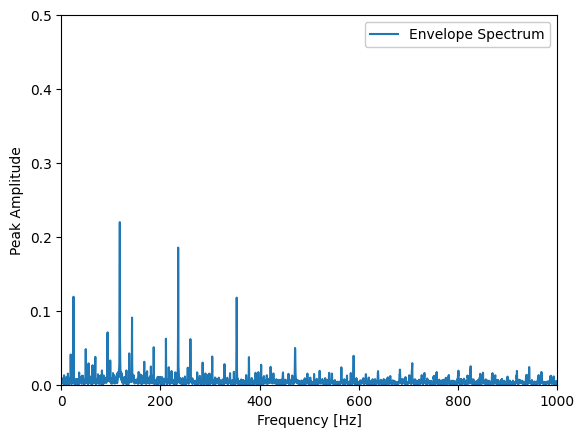

In [4]:
file_to_load = 'InnerRaceFault_vload_1.mat'
title = file_to_load.split('.')[0]


x_IRF_1, f_IRF_1, t_IRF_1, IRFDATA = Load(file_to_load)



num = int(len(t_IRF_1)*0.001)

freq, psd, L = PSD(x_IRF_1, t_IRF_1, num)

# plot_psd(freq, psd, L, title)

# Spec(np.transpose(x_IRF_1[:num])[0], f_IRF_1[0], title)

p_env, f_env, x_env = env_spectrum(np.transpose(x_IRF_1[:])[0],  f_IRF_1[0])



plot_env_spectrum(x_env, x_IRF_1, t_IRF_1)
# plt.ylim(0, 10)

plot_env_spectrum_analysis(f_env, p_env, IRFDATA)

# Wavelet

wavelet='db1'
scales = (1, len(x_IRF_1))
coeffs = pywt.wavedec(x_IRF_1, wavelet)

recon = wavelet_filter(coeffs, wavelet)
title = "Recon Inner Fault 1"

p_env, f_env, x_env = env_spectrum(np.transpose(recon)[0],  f_IRF_1[0])


plot_env_spectrum_analysis(f_env, p_env, IRFDATA)





## Baseline 1

c:\Users\Usuario\Documents\Python\Rolling-Fault-FFT-Wavelet-Analysis\env\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Usuario\Documents\Python\Rolling-Fault-FFT-Wavelet-Analysis\env\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


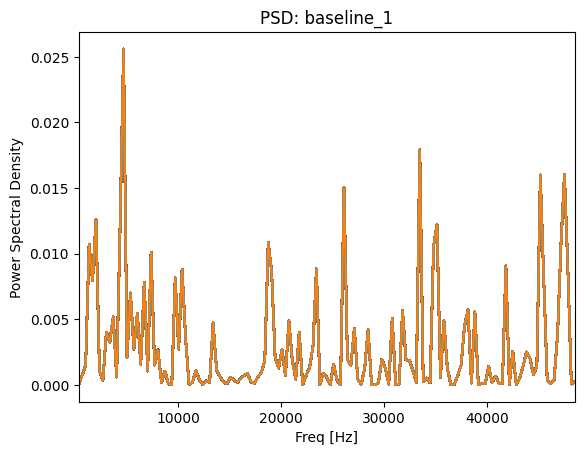

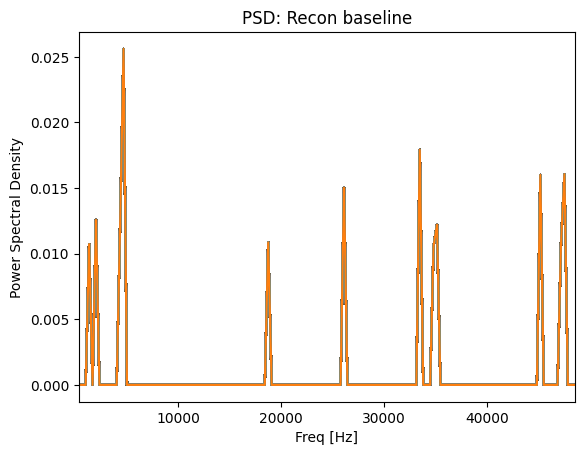

In [5]:
file_to_load = 'baseline_1.mat'
title = file_to_load.split('.')[0]

x_bsln_1, f_bsln_1, t_bsln_1, BSLN_DATA = Load(file_to_load)
num = int(len(t_bsln_1)*0.0005)

freq, psd, L = PSD(x_bsln_1, t_bsln_1, num)

plot_psd(freq, psd, L, title)


# Spec(np.transpose(x_bsln_1[:num])[0], f_bsln_1[0], title)


#Wavelet test

wavelet='db1'
scales = (1, len(x_bsln_1))
coeffs = pywt.wavedec(x_bsln_1, wavelet)

recon = wavelet_filter(coeffs, wavelet)
title = "Recon baseline"

freq, psd, L = PSD(recon, t_bsln_1, num)

plot_psd(freq, psd, L, title)

# Spec(np.transpose(recon[:num])[0], f_bsln_1[0], title='Recon')


## Envelope Spectrum: Normal

(0.0, 0.02)

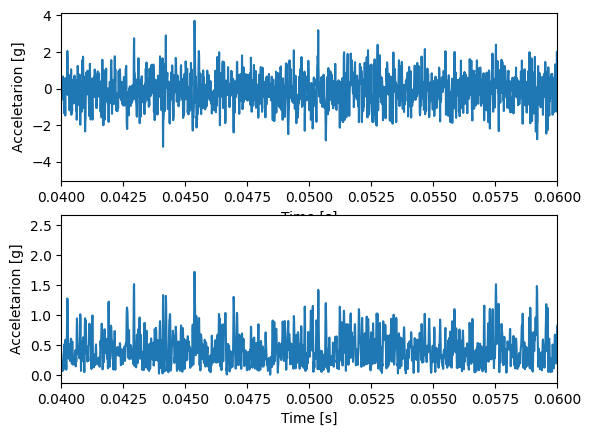

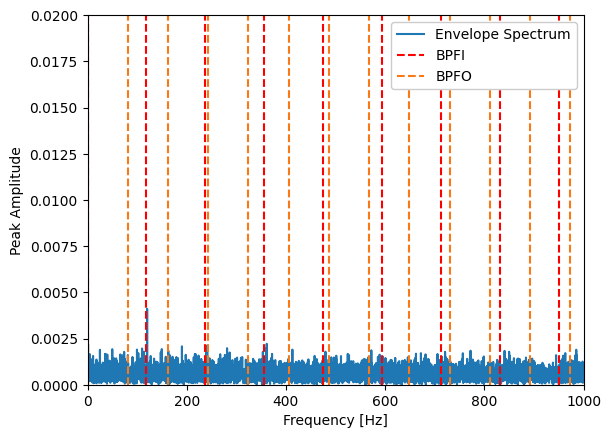

In [6]:
p_env, f_env, x_env = env_spectrum(np.transpose(x_bsln_1)[0],  f_bsln_1[0])

plot_env_spectrum(x_env, x_bsln_1, t_bsln_1)

plot_env_spectrum_analysis(f_env, p_env, BSLN_DATA, ALL=True)
plt.ylim(0, 2E-2)


# Outer Fault Analysis


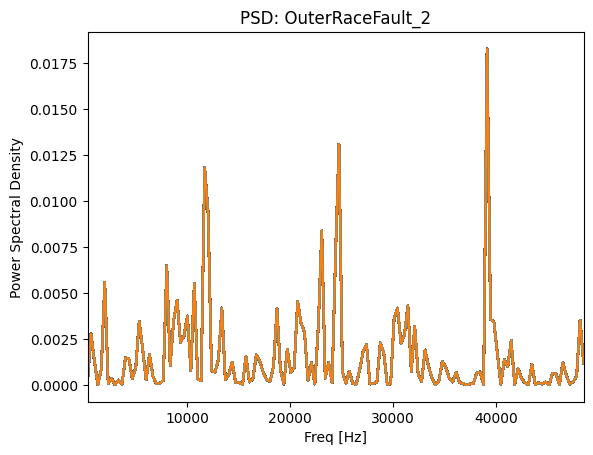

In [7]:
file_to_load = 'OuterRaceFault_2.mat'
title = file_to_load.split('.')[0]

x_ORF_2, f_ORF_2, t_ORF_2, ORF_DATA = Load(file_to_load)
num = int(len(t_ORF_2)*0.0005)

freq, psd, L = PSD(x_ORF_2, t_ORF_2, num)

plot_psd(freq, psd, L, title)


# Spec(np.transpose(x_ORF_2[:num])[0], f_ORF_2[0], title)


#Wavelet test

# wavelet='db1'
# scales = (1, len(x_ORF_2))
# coeffs = pywt.wavedec(x_ORF_2, wavelet)

# recon = wavelet_filter(coeffs, wavelet)
# title = "Recon baseline"

# freq, psd, L = PSD(recon, t_ORF_2, num)

# plot_psd(freq, psd, L, title)

# Spec(np.transpose(recon[:num])[0], f_bsln_1[0], title='Recon')

## Envelope Spectrum: Outer Fault

(0.0, 0.1)

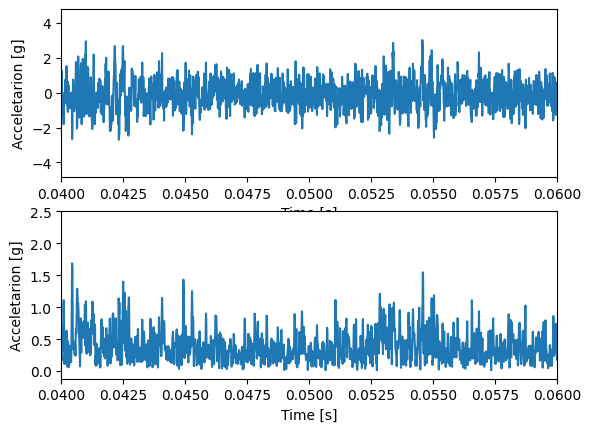

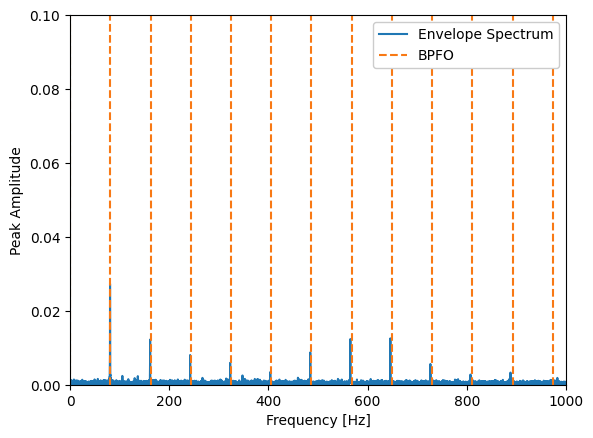

In [8]:
p_env, f_env, x_env = env_spectrum(np.transpose(x_ORF_2)[0],  f_ORF_2[0])

plot_env_spectrum(x_env, x_ORF_2, t_ORF_2)

plot_env_spectrum_analysis(f_env, p_env, ORF_DATA, BPFO=True)
plt.ylim(0, 0.1)

# TUDO TESTE AQUI PRA BAIXO

In [9]:
pywt.cwt(np.transpose(x_ORF_2)[0][:5], 2, 'gaus1')

(array([[-0.3646155 , -0.53587924, -0.45282098,  0.10009352,  0.61933131]]),
 array([0.1]))

In [10]:
k = [2, 4, 6, 8, 12, 16, 24, 32, 48, 64, 96, 128, 192, 256, 384, 512, 786, 1024]
a = []

for v in k:
    a.append(pywt.cwt(np.transpose(x_ORF_2)[0], v, 'mexh', method='fft', sampling_period=1/f_ORF_2))
    # test = pywt.waverec(a[0], wavelet='gaus1')

a

[(array([[-0.07377927,  0.38916327,  0.97108588, ...,  0.12068666,
          -0.00575087, -0.19216752]]),
  array([12207.])),
 (array([[ 0.55887254,  0.62240736,  0.53229305, ..., -1.04240138,
          -0.5360711 , -0.08012905]]),
  array([6103.5])),
 (array([[ 0.37339072,  0.31261637,  0.27755385, ..., -1.86687423,
          -1.40499744, -0.98105946]]),
  array([4069.])),
 (array([[ 0.29542618,  0.28266053,  0.25539025, ..., -2.08825267,
          -1.79814151, -1.45119225]]),
  array([3051.75])),
 (array([[ 0.24529618,  0.29864465,  0.17378089, ..., -2.04039913,
          -1.95224927, -1.70574261]]),
  array([2034.5])),
 (array([[ 0.46222569,  0.48348496,  0.50350021, ..., -1.60802254,
          -1.57017684, -1.51001476]]),
  array([1525.875])),
 (array([[ 0.49832532,  0.49370322,  0.48917825, ..., -1.23404221,
          -1.16762214, -1.2252044 ]]),
  array([1017.25])),
 (array([[ 0.25866256,  0.23049648,  0.20083705, ..., -1.67321699,
          -1.61664441, -1.55722829]]),
  array([

In [11]:
p = [j[0][0] for j in a]
# p=np.stack(p)
# p


Text(0, 0.5, 'Level (Windows Length)')

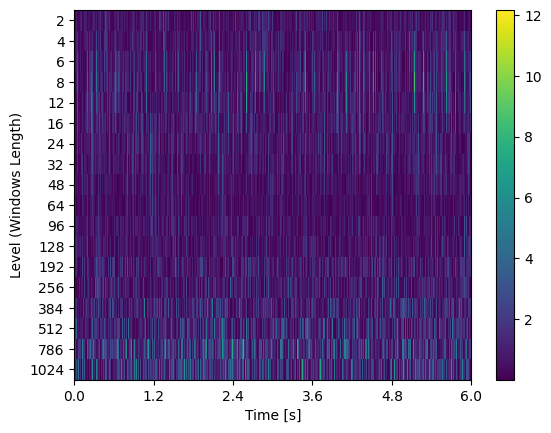

In [12]:
plt.figure()
plt.imshow(np.abs(np.stack(p)), aspect='auto', interpolation='nearest')
plt.colorbar()
time_indx = np.linspace(0, t_ORF_2.shape[0] - 1, 6, dtype=int)
time = np.round(t_ORF_2[time_indx], 2)
plt.xticks(ticks=time_indx, labels=time)
plt.yticks(ticks=np.arange(0, len(k)), labels=k)

plt.xlabel('Time [s]')
plt.ylabel('Level (Windows Length)')

# Kurtogram Analysis

C:\Users\Usuario\AppData\Local\Temp\ipykernel_5396\1620198320.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xlavel = np.array(np.arange(0, f_ORF_2/2+f_ORF_2/2/7, f_ORF_2/2/7), dtype=int)


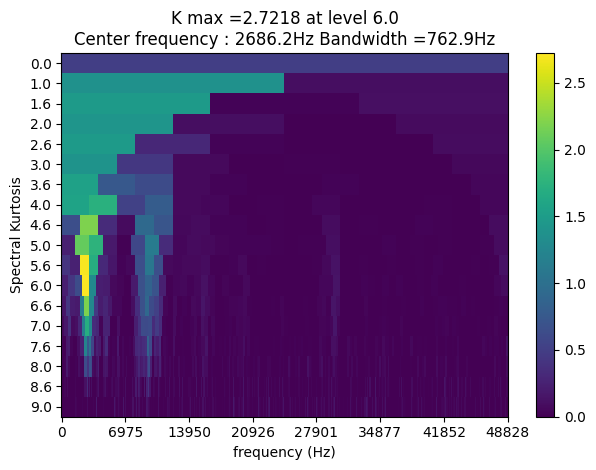

In [29]:


Kwav, Level_w, freq_w, c, max_Kurt, bandwidth, level_max = fast_kurtogram(x_ORF_2, f_ORF_2, 9)   # Center frequency & bandwidth obtained from kurtogram
minw = np.where(Level_w == level_max)[0][0]
kurtw = np.where(Kwav[minw, :] == max_Kurt)[0][0]
bandw = freq_w[kurtw]
ax = plt.gca()
im = ax.imshow(Kwav, interpolation='none', aspect='auto')
xlavel = np.array(np.arange(0, f_ORF_2/2+f_ORF_2/2/7, f_ORF_2/2/7), dtype=int)
plt.xticks(np.arange(0, Kwav.shape[1], Kwav.shape[1] // 7), labels=xlavel)
plt.title(f'K max ={max_Kurt:.4f} at level {level_max:.1f}\nCenter frequency : {bandw + bandwidth[0]/2:.1f}Hz Bandwidth ={bandwidth[0]:.1f}Hz')
plt.xlabel('frequency (Hz)')
plt.yticks(np.arange(0, Kwav.shape[0], 1), labels=np.round(Level_w, 1))
plt.ylabel('level (window lenght)')

plt.colorbar(im)

plt.ylabel('Spectral Kurtosis')
plt.tight_layout()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_5396\2326466798.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xlavel = np.round(np.array(np.arange(0, f_ORF_2/2+f_ORF_2/2/7, f_ORF_2/2/7), dtype=int)*1E-3, 2)


Text(0, 0.5, 'level (window lenght)')

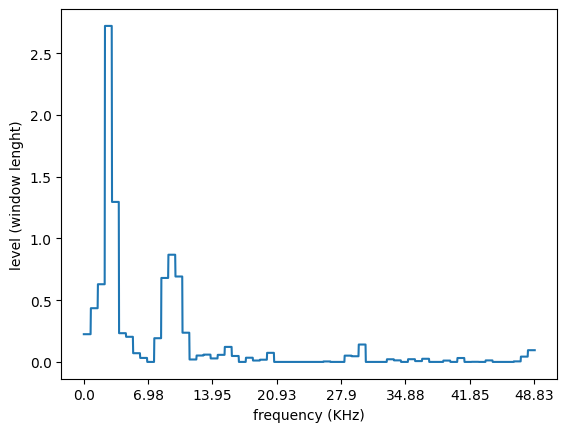

In [36]:
plt.plot(Kwav[11])
xlavel = np.round(np.array(np.arange(0, f_ORF_2/2+f_ORF_2/2/7, f_ORF_2/2/7), dtype=int)*1E-3, 2)
plt.xticks(np.arange(0, Kwav.shape[1], Kwav.shape[1] // 7), labels=xlavel)
plt.xlabel('frequency (KHz)')
# plt.yticks(np.arange(0, Kwav.shape[0], 1), labels=np.round(Level_w, 1))
plt.ylabel('level (window lenght)')

In [13]:
k = [2, 4, 6, 8, 12, 16, 24, 32, 48, 64, 96, 128, 192, 256, 384, 512, 786, 1024]
a = []

for v in k:
    a.append(pywt.wavedec(np.transpose(x_ORF_2), 'db1', level=v))
    # test = pywt.waverec(a[0], wavelet='gaus1')

a



# plt.figure()
# plt.imshow(np.stack(rec), aspect='auto', interpolation='nearest')
# plt.colorbar()
# time_indx = np.linspace(0, t_ORF_2.shape[0] - 1, 6, dtype=int)
# time = np.round(t_ORF_2[time_indx], 2)
# plt.xticks(ticks=time_indx, labels=time)
# plt.yticks(ticks=np.arange(0, len(k)), labels=k)

# plt.xlabel('Time [s]')
# plt.ylabel('Level (Windows Length)')

c:\Users\Usuario\Documents\Python\Rolling-Fault-FFT-Wavelet-Analysis\env\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 24 is too high: all coefficients will experience boundary effects.
  warnings.warn(
c:\Users\Usuario\Documents\Python\Rolling-Fault-FFT-Wavelet-Analysis\env\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 32 is too high: all coefficients will experience boundary effects.
  warnings.warn(
c:\Users\Usuario\Documents\Python\Rolling-Fault-FFT-Wavelet-Analysis\env\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 48 is too high: all coefficients will experience boundary effects.
  warnings.warn(
c:\Users\Usuario\Documents\Python\Rolling-Fault-FFT-Wavelet-Analysis\env\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 64 is too high: all coefficients will experience boundary effects.
  warnings.warn(
c:\Users\Usuario\Documents\Python\Rolling-Fault-FFT-Wavelet-Analysis\env\Lib\site-packages\p

[[array([[ 0.8266473 , -0.96423842,  0.24676174, ..., -1.56313617,
          -2.11494615, -1.4086062 ]]),
  array([[-0.690693  ,  0.44504508,  0.05959077, ...,  1.48987983,
          -0.13288985,  0.5113917 ]]),
  array([[ 0.3398807 ,  0.19970824,  0.34444901, ...,  0.09337607,
          -1.05885104,  0.01900413]])],
 [array([[ 0.17149644,  0.27513878, -2.28330464, ..., -1.57676468,
          -0.0194925 , -2.32104332]]),
  array([[-0.30908755, -1.13228593, -0.53007496, ..., -1.00824958,
           0.19533595,  1.20250903]]),
  array([[ 1.26634744,  0.0091496 ,  0.04873723, ...,  0.59133238,
           1.41968519, -0.49945777]]),
  array([[-0.690693  ,  0.44504508,  0.05959077, ...,  1.48987983,
          -0.13288985,  0.5113917 ]]),
  array([[ 0.3398807 ,  0.19970824,  0.34444901, ...,  0.09337607,
          -1.05885104,  0.01900413]])],
 [array([[-0.40144108, -0.9884837 , -1.03485196, ..., -3.43141435,
           0.54854271, -4.64208664]]),
  array([[ 0.84807629,  0.43820908, -0.47020

In [14]:
a[3]

[array([[-1.74503043, -2.94291019, -1.4789556 , ..., -2.44348362,
         -2.28324178, -3.93707214]]),
 array([[ 0.35510565,  0.17048753,  0.1947819 , ..., -1.09851961,
          2.22819799,  0.15647179]]),
 array([[ 0.41510182,  0.02151878,  0.30516403, ..., -0.42990214,
          2.17946458,  3.67032921]]),
 array([[ 0.84807629,  0.43820908, -0.47020703, ..., -1.78843195,
          2.14479989,  0.        ]]),
 array([[-0.0732862 , -2.34553819, -1.63943076, ...,  3.52383065,
         -1.10115772,  0.        ]]),
 array([[-0.30908755, -1.13228593, -0.53007496, ..., -1.00824958,
          0.19533595,  1.20250903]]),
 array([[ 1.26634744,  0.0091496 ,  0.04873723, ...,  0.59133238,
          1.41968519, -0.49945777]]),
 array([[-0.690693  ,  0.44504508,  0.05959077, ...,  1.48987983,
         -0.13288985,  0.5113917 ]]),
 array([[ 0.3398807 ,  0.19970824,  0.34444901, ...,  0.09337607,
         -1.05885104,  0.01900413]])]

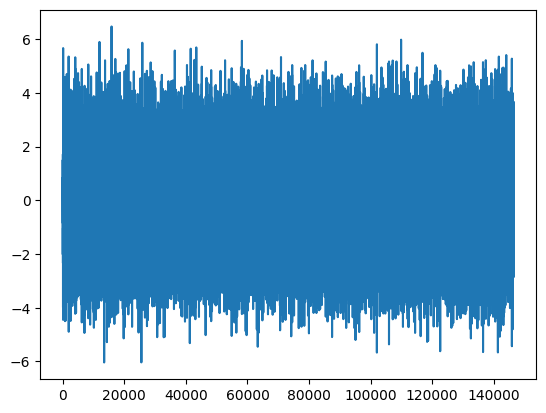

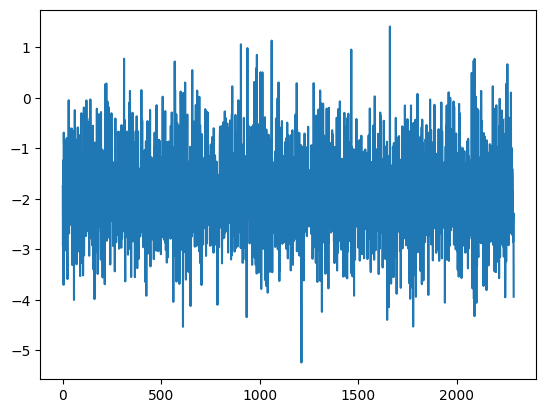

In [15]:
plt.plot(a[0][0][0])

plt.figure()

plt.plot(a[3][0][0])
# plt.ylim(-8, 8)



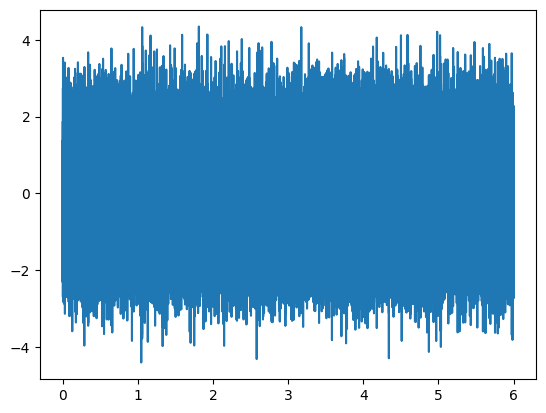

In [16]:
plt.plot(t_ORF_2, pywt.waverec(a[3], 'db1')[0])

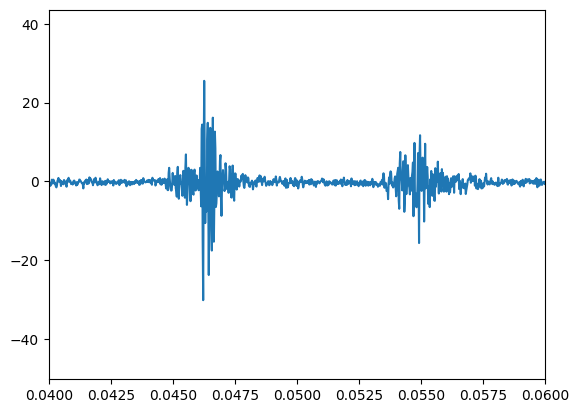

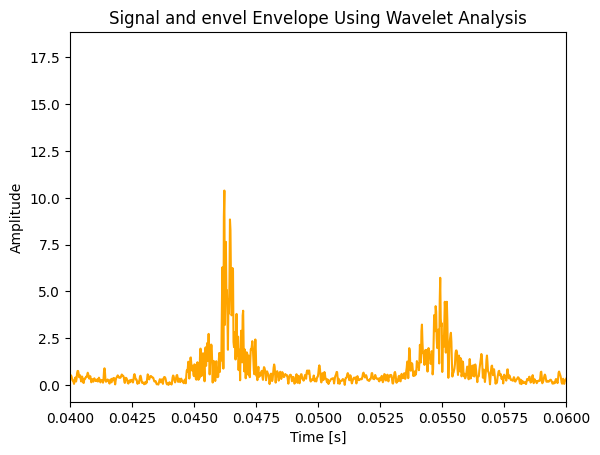

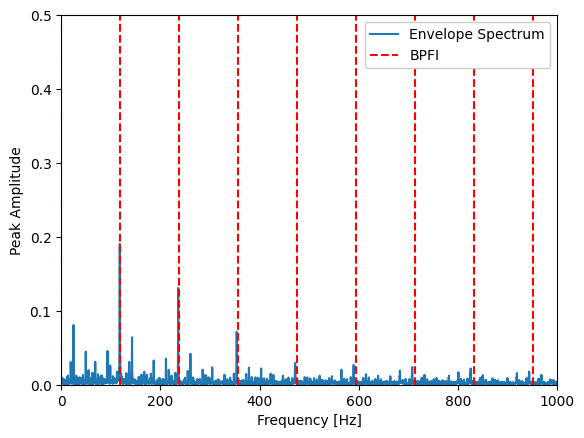

In [20]:
# from scipy.signal import demod
# cA, _ = pywt.cwt(x_IRF_1, k[4],  'cmor')
file_to_load = 'InnerRaceFault_vload_1.mat'


x_IRF_1, f_IRF_1, t_IRF_1, IRFDATA = Load(file_to_load)
x_IRF_1 = np.transpose(x_IRF_1)[0]
# t_IRF_1 = np.transpose(t_IRF_1)


wavelet = 'db1'  # Daubechies wavelet
coeffs = pywt.wavedec(x_IRF_1, wavelet)

# Get the approximation coefficients
cA = coeffs[0]

# Create the envelope by upsampling the approximation coefficients
# [[[[QUASE]]]]

p_env, f_env, x_env = env_spectrum(x_IRF_1, f_IRF_1)


plt.plot(t_IRF_1, x_IRF_1, label='Original Signal')
plt.xlim(0.04, 0.06)

plt.figure()
plt.plot(t_IRF_1, x_env[:len(t_IRF_1)], label='Envelope', color='orange')
plt.title('Signal and envel Envelope Using Wavelet Analysis')
plt.xlim(0.04, 0.06)
# plt.ylim(0, 10)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')


plot_env_spectrum_analysis(f_env, p_env, IRFDATA, BPFI=True)
# plt.legend()

In [21]:
fast_kurtogram(x_IRF_1, f_bsln_1)

NameError: name 'fast_kurtogram' is not defined